In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['figure.dpi'] = 150

# Loading in the Data

We saved the cleaned data to a file in the `data-cleaning` notebook, so let's load that data in.

In [2]:
data_file = Path("./data", "cleaned_data.hdf")
match_2018_train_df = pd.read_hdf(data_file, "clean_data")

In [3]:
match_2018_train_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
0,2018-M020,Brisbane,Hard,32,A,2018-01-01,300,106401,Nick Kyrgios,R,...,5.0,8.0,3.0,58.0,32.0,22.0,12.0,9.0,4.0,7.0
1,2018-M020,Brisbane,Hard,32,A,2018-01-01,299,106401,Nick Kyrgios,R,...,2.0,5.0,6.0,74.0,44.0,32.0,16.0,13.0,3.0,6.0
2,2018-M020,Brisbane,Hard,32,A,2018-01-01,298,105992,Ryan Harrison,R,...,6.0,9.0,5.0,94.0,62.0,49.0,16.0,16.0,0.0,3.0
3,2018-M020,Brisbane,Hard,32,A,2018-01-01,297,105777,Grigor Dimitrov,R,...,2.0,6.0,1.0,89.0,53.0,39.0,23.0,15.0,4.0,6.0
4,2018-M020,Brisbane,Hard,32,A,2018-01-01,296,106401,Nick Kyrgios,R,...,3.0,6.0,3.0,75.0,41.0,33.0,16.0,13.0,2.0,4.0


# Feature Selection / Engineering Part 1

Since we know both the winner's and loser's match information for each match, we can visualize their distributions to identify which features are strong in determining the winner of a match.

To standardize the match statistics, I convert them to percentages.

In [4]:
def convert_match_stats_to_percent(data):
    data['w_ace%'] = data['w_ace'] / data['w_svpt']
    data['l_ace%'] = data['l_ace'] / data['l_svpt']
    
    data['w_df%'] = data['w_df'] / data['w_svpt']
    data['l_df%'] = data['l_df'] / data['l_svpt']
    
    data['w_1stIn%'] = data['w_1stIn'] / data['w_svpt']
    data['l_1stIn%'] = data['l_1stIn'] / data['l_svpt']
    
    data['w_1stWon%'] = data['w_1stWon'] / data['w_1stIn']
    data['l_1stWon%'] = data['l_1stWon'] / data['l_1stIn']
    
    data['w_2ndWon%'] = data['w_2ndWon'] / (data['w_svpt'] - data['w_1stIn'])
    data['l_2ndWon%'] = data['l_2ndWon'] / (data['l_svpt'] - data['l_1stIn'])
    
    data['w_bpSaved%'] = data['w_bpSaved'] / data['w_bpFaced']
    data['l_bpSaved%'] = data['l_bpSaved'] / data['l_bpFaced']
    
    data['w_bpFaced%'] = data['w_bpFaced'] / data['w_svpt']
    data['l_bpFaced%'] = data['l_bpFaced'] / data['l_svpt']
    
    return data

convert_match_stats_to_percent(match_2018_train_df).head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,w_1stIn%,l_1stIn%,w_1stWon%,l_1stWon%,w_2ndWon%,l_2ndWon%,w_bpSaved%,l_bpSaved%,w_bpFaced%,l_bpFaced%
0,2018-M020,Brisbane,Hard,32,A,2018-01-01,300,106401,Nick Kyrgios,R,...,0.714286,0.551724,0.825000,0.687500,0.562500,0.461538,1.000000,0.571429,0.089286,0.120690
1,2018-M020,Brisbane,Hard,32,A,2018-01-01,299,106401,Nick Kyrgios,R,...,0.694444,0.594595,0.820000,0.727273,0.500000,0.533333,0.500000,0.500000,0.027778,0.081081
2,2018-M020,Brisbane,Hard,32,A,2018-01-01,298,105992,Ryan Harrison,R,...,0.608696,0.659574,0.700000,0.790323,0.533333,0.500000,0.500000,0.000000,0.052174,0.031915
3,2018-M020,Brisbane,Hard,32,A,2018-01-01,297,105777,Grigor Dimitrov,R,...,0.631068,0.595506,0.830769,0.735849,0.473684,0.638889,1.000000,0.666667,0.019417,0.067416
4,2018-M020,Brisbane,Hard,32,A,2018-01-01,296,106401,Nick Kyrgios,R,...,0.623188,0.546667,0.883721,0.804878,0.423077,0.470588,0.333333,0.500000,0.043478,0.053333


In [5]:
assert match_2018_train_df['w_ace%'].max() <= 1 and match_2018_train_df['w_ace%'].min() >= 0
assert match_2018_train_df['l_ace%'].max() <= 1 and match_2018_train_df['l_ace%'].min() >= 0
assert match_2018_train_df['w_df%'].max() <= 1 and match_2018_train_df['w_df%'].min() >= 0
assert match_2018_train_df['l_df%'].max() <= 1 and match_2018_train_df['l_df%'].min() >= 0
assert match_2018_train_df['w_1stIn%'].max() <= 1 and match_2018_train_df['w_1stIn%'].min() >= 0
assert match_2018_train_df['l_1stIn%'].max() <= 1 and match_2018_train_df['l_1stIn%'].min() >= 0
assert match_2018_train_df['w_1stWon%'].max() <= 1 and match_2018_train_df['w_1stWon%'].min() >= 0
assert match_2018_train_df['l_1stWon%'].max() <= 1 and match_2018_train_df['l_1stWon%'].min() >= 0
assert match_2018_train_df['w_2ndWon%'].max() <= 1 and match_2018_train_df['w_2ndWon%'].min() >= 0
assert match_2018_train_df['l_2ndWon%'].max() <= 1 and match_2018_train_df['l_2ndWon%'].min() >= 0
assert match_2018_train_df['w_bpSaved%'].max() <= 1 and match_2018_train_df['w_bpSaved%'].min() >= 0
assert match_2018_train_df['l_bpSaved%'].max() <= 1 and match_2018_train_df['l_bpSaved%'].min() >= 0
assert match_2018_train_df['w_bpFaced%'].max() <= 1 and match_2018_train_df['w_bpFaced%'].min() >= 0
assert match_2018_train_df['l_bpFaced%'].max() <= 1 and match_2018_train_df['l_bpFaced%'].min() >= 0

In [6]:
def plot_dist(winner_col_name, loser_col_name, stat_name):
    sns.distplot(match_2018_train_df[winner_col_name], hist=False, label=f"{stat_name} for winner")
    sns.distplot(match_2018_train_df[loser_col_name], hist=False, label=f"{stat_name} for loser")
    plt.title(f"Distribution of {stat_name}")
    plt.xlabel(f"{stat_name}")
    plt.legend()

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


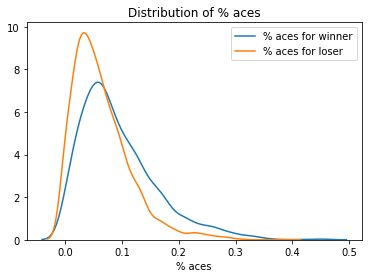

In [7]:
plot_dist('w_ace%', 'l_ace%', '% aces')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


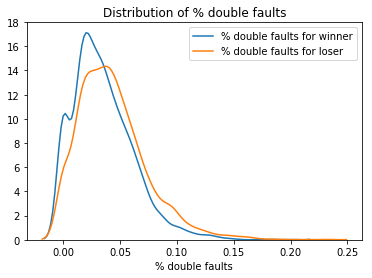

In [8]:
plot_dist('w_df%', 'l_df%', '% double faults')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


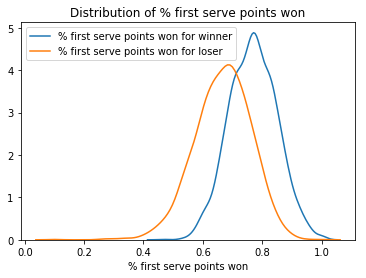

In [9]:
plot_dist('w_1stWon%', 'l_1stWon%', '% first serve points won')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


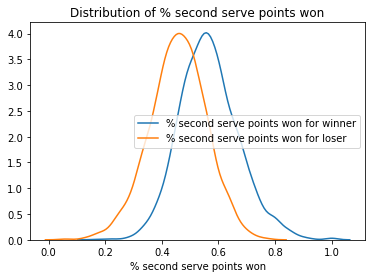

In [10]:
plot_dist('w_2ndWon%', 'l_2ndWon%', '% second serve points won')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


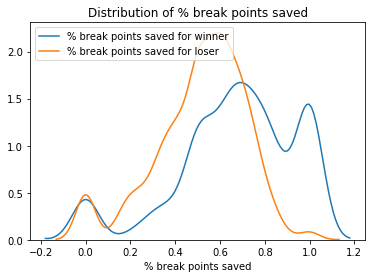

In [11]:
plot_dist('w_bpSaved%', 'l_bpSaved%', '% break points saved')

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


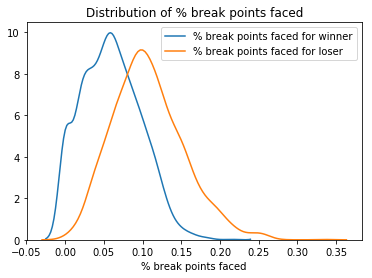

In [12]:
plot_dist('w_bpFaced%', 'l_bpFaced%', '% break points faced')

In any professional sport, especially professional tennis, the margin between victory and defeat is small. Therefore, I believe it is reasonable to say that if the difference between the peaks of the distribution of a match statistic for winners vs. losers is near 10% or above, then that match statistic is likely to be a good candidate for a strong feature in our model. Based on this reasoning, it seems the `% aces`, `% first serve points won`, and `% second serve points won` will likely be strong features. `% break points faced` may be a good feature, as the difference between the peaks of the distribution is around 5%. The distribution of `% break points saved` is not smooth due to undefined values when a player does not face a break point, but from domain knowledge I expect `% break points saved` to be a strong feature.

Because we are going to use `% break points saved` as a feature, we have to plug in a replacement value for when the `% break points saved` is `NaN` (undefined). Normally, 0 is a good candidate, but 0 does not make sense here because it means that the player saved none of the break points they faced. However, for the `% break points saved` to be undefined, the player had to have faced ***no*** break points. If a player does not face any break points, it does not make sense to penalize them by saying they saved 0% of their break points. Rather, it seems fair to reward them by saying they saved 100% of their break points.

In [13]:
def replace_nan_bp(data):
    data['w_bpSaved%'].replace(to_replace=np.NaN, value=1, inplace=True)
    data['l_bpSaved%'].replace(to_replace=np.NaN, value=1, inplace=True)
    return data

In [14]:
replace_nan_bp(match_2018_train_df).head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,w_1stIn%,l_1stIn%,w_1stWon%,l_1stWon%,w_2ndWon%,l_2ndWon%,w_bpSaved%,l_bpSaved%,w_bpFaced%,l_bpFaced%
0,2018-M020,Brisbane,Hard,32,A,2018-01-01,300,106401,Nick Kyrgios,R,...,0.714286,0.551724,0.825000,0.687500,0.562500,0.461538,1.000000,0.571429,0.089286,0.120690
1,2018-M020,Brisbane,Hard,32,A,2018-01-01,299,106401,Nick Kyrgios,R,...,0.694444,0.594595,0.820000,0.727273,0.500000,0.533333,0.500000,0.500000,0.027778,0.081081
2,2018-M020,Brisbane,Hard,32,A,2018-01-01,298,105992,Ryan Harrison,R,...,0.608696,0.659574,0.700000,0.790323,0.533333,0.500000,0.500000,0.000000,0.052174,0.031915
3,2018-M020,Brisbane,Hard,32,A,2018-01-01,297,105777,Grigor Dimitrov,R,...,0.631068,0.595506,0.830769,0.735849,0.473684,0.638889,1.000000,0.666667,0.019417,0.067416
4,2018-M020,Brisbane,Hard,32,A,2018-01-01,296,106401,Nick Kyrgios,R,...,0.623188,0.546667,0.883721,0.804878,0.423077,0.470588,0.333333,0.500000,0.043478,0.053333


# Setting Up for Feature Engineering Part 2

## Filtering the Training Data

In general, training data has to consist of data representative of the same population as the input we are trying to make predictions about. In this context, what that means is if we are, for example, trying to predict the outcome of a match between Roger Federer and Rafael Nadal, our training data should consist of all matches played by Federer OR all matches played by Nadal. Therefore, each player in the dataset will have their own model that predicts their performance against an opponent. From this point forward, I will be constructing the model for Roger Federer to illustrate my thought process through developing the model.

In [15]:
def get_matches_for_player(data, player):
    """Returns a DataFrame containing all matches in DATA in which PLAYER played."""
    return data[(data['winner_name'] == player) | (data['loser_name'] == player)]

We also need to split the data into a training set and a testing set in order to evaluate our model.

In [16]:
fed_2018_all = get_matches_for_player(match_2018_train_df, "Roger Federer")

from sklearn.model_selection import train_test_split
fed_2018, fed_2018_test = train_test_split(fed_2018_all, test_size=0.1)
fed_2018.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,w_1stIn%,l_1stIn%,w_1stWon%,l_1stWon%,w_2ndWon%,l_2ndWon%,w_bpSaved%,l_bpSaved%,w_bpFaced%,l_bpFaced%
234,2018-580,Australian Open,Hard,128,G,2018-01-15,232,103819,Roger Federer,R,...,0.576087,0.504673,0.830189,0.759259,0.666667,0.509434,0.666667,0.727273,0.032609,0.102804
1420,2018-0500,Halle,Grass,32,A,2018-06-18,293,103819,Roger Federer,R,...,0.633333,0.578947,0.736842,0.712121,0.606061,0.500000,0.600000,0.714286,0.055556,0.061404
262,2018-580,Australian Open,Hard,128,G,2018-01-15,504,103819,Roger Federer,R,...,0.625000,0.563830,0.833333,0.698113,0.527778,0.512195,0.600000,0.500000,0.052083,0.085106
1389,2018-0321,Stuttgart,Grass,32,A,2018-06-11,297,103819,Roger Federer,R,...,0.625000,0.649123,0.828571,0.648649,0.714286,0.700000,1.000000,0.666667,0.035714,0.105263
610,2018-M006,Indian Wells Masters,Hard,128,M,2018-03-05,300,105223,Juan Martin Del Potro,R,...,0.626087,0.608696,0.750000,0.742857,0.674419,0.533333,0.750000,0.600000,0.034783,0.043478


In [17]:
assert fed_2018_all[fed_2018_all['winner_name'] == "Roger Federer"].shape == match_2018_train_df[match_2018_train_df["winner_name"] == "Roger Federer"].shape
assert fed_2018_all[fed_2018_all['loser_name'] == "Roger Federer"].shape == match_2018_train_df[match_2018_train_df["loser_name"] == "Roger Federer"].shape

## Adding a Variable to Predict

Since our ultimate goal is to predict the outcome of a match, we need to have a binary variable representing whether the match resulted in a win or a loss for a given player. This binary variable will the variable we will try to predict with our model.

In [18]:
def add_win_loss(data, player):
    data['result'] = data['winner_name'].apply(lambda w: 1 if w == player else 0)
    return data

In [19]:
add_win_loss(fed_2018, "Roger Federer").head()

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stIn%,w_1stWon%,l_1stWon%,w_2ndWon%,l_2ndWon%,w_bpSaved%,l_bpSaved%,w_bpFaced%,l_bpFaced%,result
234,2018-580,Australian Open,Hard,128,G,2018-01-15,232,103819,Roger Federer,R,...,0.504673,0.830189,0.759259,0.666667,0.509434,0.666667,0.727273,0.032609,0.102804,1
1420,2018-0500,Halle,Grass,32,A,2018-06-18,293,103819,Roger Federer,R,...,0.578947,0.736842,0.712121,0.606061,0.500000,0.600000,0.714286,0.055556,0.061404,1
262,2018-580,Australian Open,Hard,128,G,2018-01-15,504,103819,Roger Federer,R,...,0.563830,0.833333,0.698113,0.527778,0.512195,0.600000,0.500000,0.052083,0.085106,1
1389,2018-0321,Stuttgart,Grass,32,A,2018-06-11,297,103819,Roger Federer,R,...,0.649123,0.828571,0.648649,0.714286,0.700000,1.000000,0.666667,0.035714,0.105263,1
610,2018-M006,Indian Wells Masters,Hard,128,M,2018-03-05,300,105223,Juan Martin Del Potro,R,...,0.608696,0.750000,0.742857,0.674419,0.533333,0.750000,0.600000,0.034783,0.043478,0


In [20]:
fed_2018['result'].value_counts()

1    32
0     5
Name: result, dtype: int64

# Feature Engineering Part 2

There are other features which are not directly captured by the dataset that I believe will be useful in predicting the outcome of match.

## Win Streak

I define win streak as the number of consecutive wins a player has coming into a match. In other words, if match $X$ occurs on day $Y$, the win streak of player $Z$ is the number of consecutive wins player $Z$ has starting with match $X-1$ in the matches {$X-1, X-2, ..., 1$} (where all matches $<X$ occur before day $Y$) if player $Z$ won match $X-1$. If player $Z$ lost match $X-1$, player $Z$'s win streak is $0$. For example, if I played $4$ matches and the outcomes were {Win, Loss, Win, Win}, then my win streak heading into match $5$ is $2$.

To compute the win streak, I sort the matches chronologically, convert the results into a string of 0's and 1's, and compute the length of the streak of 1's at the end, if there is a 1 at the end.

In [21]:
def compute_win_streak(results):
    result_string = results.apply(lambda x: str(x)).str.cat()
    streak = re.findall(r"1+$", result_string)
    if not streak:
        return 0
    else:
        return len(streak[0])

In [22]:
def add_win_streak(data):
    """Adds a column to DATA containing the win streak for every match. Also sorts DATA chronologically."""
    data.sort_values(by=['tourney_date', 'match_num'], inplace=True)
    result = data['result']
    streaks = []
    for i in range(1, len(result)+1):
        so_far = result.iloc[:i]
        streaks.append(compute_win_streak(so_far))
    data['win_streak'] = pd.Series(streaks, index=data.index)
    return data

In [23]:
add_win_streak(fed_2018).head()

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,w_1stWon%,l_1stWon%,w_2ndWon%,l_2ndWon%,w_bpSaved%,l_bpSaved%,w_bpFaced%,l_bpFaced%,result,win_streak
234,2018-580,Australian Open,Hard,128,G,2018-01-15,232,103819,Roger Federer,R,...,0.830189,0.759259,0.666667,0.509434,0.666667,0.727273,0.032609,0.102804,1,1
258,2018-580,Australian Open,Hard,128,G,2018-01-15,408,103819,Roger Federer,R,...,0.833333,0.666667,0.757576,0.529412,1.000000,0.700000,0.000000,0.092593,1,2
262,2018-580,Australian Open,Hard,128,G,2018-01-15,504,103819,Roger Federer,R,...,0.833333,0.698113,0.527778,0.512195,0.600000,0.500000,0.052083,0.085106,1,3
264,2018-580,Australian Open,Hard,128,G,2018-01-15,602,103819,Roger Federer,R,...,0.937500,0.566667,0.714286,0.391304,1.000000,0.636364,0.027027,0.207547,1,4
265,2018-580,Australian Open,Hard,128,G,2018-01-15,701,103819,Roger Federer,R,...,0.797619,0.693182,0.581818,0.509434,0.777778,0.538462,0.064748,0.092199,1,5


In [24]:
assert fed_2018['win_streak'].min() >= 0 and fed_2018['win_streak'].max() <= fed_2018.shape[0]

## Head to Head

I define head to head for player $X$ against $Y$ as the percentage of matches player $X$ has won against player $Y$. For each match, I compute the head to head for player $X$ against the opponent  considering all matches in the training set chronologically before that match.

In [25]:
def compute_head_to_head(data, row, player):
    match_date = row['tourney_date']
    if row['winner_name'] == player:
        other_player = row['loser_name']
    else:
        other_player = row['winner_name']
    head_to_head_matches = data[((data['winner_name'] == other_player) | (data['loser_name'] == other_player))
                               & (data['tourney_date'] <= match_date)]
    total_matches = head_to_head_matches.shape[0]
    player_wins = head_to_head_matches[head_to_head_matches['winner_name'] == player].shape[0]
    return player_wins/total_matches

def add_head_to_head(data):
    data['head_to_head'] = data.apply(lambda row: compute_head_to_head(data, row, "Roger Federer"), axis=1)
    return data

In [26]:
add_head_to_head(fed_2018).head()

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stWon%,w_2ndWon%,l_2ndWon%,w_bpSaved%,l_bpSaved%,w_bpFaced%,l_bpFaced%,result,win_streak,head_to_head
234,2018-580,Australian Open,Hard,128,G,2018-01-15,232,103819,Roger Federer,R,...,0.759259,0.666667,0.509434,0.666667,0.727273,0.032609,0.102804,1,1,1.0
258,2018-580,Australian Open,Hard,128,G,2018-01-15,408,103819,Roger Federer,R,...,0.666667,0.757576,0.529412,1.000000,0.700000,0.000000,0.092593,1,2,1.0
262,2018-580,Australian Open,Hard,128,G,2018-01-15,504,103819,Roger Federer,R,...,0.698113,0.527778,0.512195,0.600000,0.500000,0.052083,0.085106,1,3,1.0
264,2018-580,Australian Open,Hard,128,G,2018-01-15,602,103819,Roger Federer,R,...,0.566667,0.714286,0.391304,1.000000,0.636364,0.027027,0.207547,1,4,1.0
265,2018-580,Australian Open,Hard,128,G,2018-01-15,701,103819,Roger Federer,R,...,0.693182,0.581818,0.509434,0.777778,0.538462,0.064748,0.092199,1,5,1.0


In [27]:
assert fed_2018['head_to_head'].max() <= 1 and fed_2018['head_to_head'].min() >= 0

## Opponent Hand

In [28]:
def get_opponent_hand(row, player):
    if row['winner_name'] == player:
        return row['loser_hand']
    else:
        return row['winner_hand']


def add_opponent_hand(data):
    data['opponent_hand'] = data.apply(lambda row: get_opponent_hand(row, "Roger Federer"), axis=1)
    return pd.get_dummies(data, columns=['opponent_hand'])

In [29]:
fed_2018 = add_opponent_hand(fed_2018)

/Users/raguvirkunani/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Player vs. Opponent Statistics

The dataset only gives us the match statistics for the winner and the loser, not the match statistics for the player of interest (in this case, Roger Federer). We need to convert the winner and loser statistics into statistics for the player and statistics of the opponent so our model can distinguish the player of interest from the opponent.

In [30]:
def add_player_v_opponent_stats(data, player):
    match_stats = ['ace%', 'df%', '1stIn%', '1stWon%', '2ndWon%', 'bpSaved%', 'bpFaced%']
    for stat in match_stats:
        player_stat_list = []
        opp_stat_list = []
        for i in range(data.shape[0]):
            if data['winner_name'].iloc[i] == player:
                player_stat_list.append(data['w_'+stat].iloc[i])
                opp_stat_list.append(data['l_'+stat].iloc[i])
            else:
                player_stat_list.append(data['l_'+stat].iloc[i])
                opp_stat_list.append(data['w_'+stat].iloc[i])
        data['player_'+stat] = pd.Series(player_stat_list, index=data.index)
        data['opp_'+stat] = pd.Series(opp_stat_list, index=data.index)
    return data

In [31]:
fed_2018 = add_player_v_opponent_stats(fed_2018, "Roger Federer")

# Estimating Features

In Feature Selection / Engineering Part 1, we determined that `% aces`, `% first serve points won`, and `% second serve points won` and `% break points saved` will likely be strong features and `% break points faced` may be a good feature. It is important to note that these features are the statistics for a match. When we try to predict the outcome of a future match, we don't know the values of these features because the match has not happened yet. Therefore, we have to use estimates of the values of the features. Specifically, we will use the average of the feature over the training data for a given player as the estimate. For example, to estimate Federer's `% first serve points won` in a match, we will use Federer's average `% first serve points won` over the training data.

In [32]:
def get_stat(row, statistic, player):
    if row['winner_name'] == player:
        return row['w_'+statistic]
    else:
        return row['l_'+statistic]

def get_estimate(data, statistic, player):
    player_data = get_matches_for_player(data, player)
    s = player_data.apply(lambda row: get_stat(row, statistic, player), axis=1)
    return s.mean()

In [33]:
get_estimate(fed_2018, '1stWon%', "Roger Federer")

0.8280277644151912

# Saving the Data

Since these notebooks are meant to show my thought process of making the model by actually making Roger Federer's model, I will save Federer's data.

In [34]:
data_file = Path('./data', 'fed_2018.hdf')
fed_2018.to_hdf(data_file, 'fed_2018')
fed_2018_test.to_hdf(data_file, 'fed_2018_test')